## 測驗實驗2：多變量線性迴歸（Multiple Linear Regression）

延續上一份「連鎖餐廳執行長」的情境：你想評估要在哪些城市開設新的分店。

這次不只看人口數，還會同時考慮另一個重要因素（例如：當地平均收入）。


<br>

## 1 - 套件（Packages）

請先執行下方儲存格完成環境設定。


In [ ]:
import copy
import math
import sys, os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

# region 資料載入
def find_repo_root(marker="README.md"):
    cur = Path.cwd()
    while cur != cur.parent:  # 防止無限迴圈，到達檔案系統根目錄就停
        if (cur / marker).exists():
            return cur
        cur = cur.parent
    return None

def import_data_from_github():
    import urllib.request

    def isRunningInColab() -> bool:
        return "google.colab" in sys.modules

    def isRunningInJupyterLab() -> bool:
        try:
            import jupyterlab  # noqa: F401
            return True
        except ImportError:
            return False

    def detect_env():
        from IPython import get_ipython
        if isRunningInColab():
            return "Colab"
        elif isRunningInJupyterLab():
            return "JupyterLab"
        elif "notebook" in str(type(get_ipython())).lower():
            return "Jupyter Notebook"
        else:
            return "Unknown"

    def get_utils_dir(env):
        if env == "Colab":
            if "/content" not in sys.path:
                sys.path.insert(0, "/content")
            return "/content/utils"
        else:
            return Path.cwd() / "utils"

    def get_data_dir(env):
        if env == "Colab":
            if "/content" not in sys.path:
                sys.path.insert(0, "/content")
            return "/content/data"
        else:
            return Path.cwd() / "data"

    env = detect_env()
    UTILS_DIR = get_utils_dir(env)
    DATA_DIR = get_data_dir(env)

    REPO_DIR = "Machine-Learning-Lab"
    os.makedirs(UTILS_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

    BASE = f"https://raw.githubusercontent.com/mz038197/{REPO_DIR}/main"

    utils_list = ["utils.py", "public_tests.py"]
    for u in utils_list:
        urllib.request.urlretrieve(f"{BASE}/utils/{u}", f"{UTILS_DIR}/{u}")

    data_list = ["ex1data1.txt", "ex1data2.txt"]
    for d in data_list:
        urllib.request.urlretrieve(f"{BASE}/data/{d}", f"{DATA_DIR}/{d}")

repo_root = find_repo_root()
if repo_root is None:
    import_data_from_github()
    repo_root = Path.cwd()

os.chdir(repo_root)
print(f"✅ 切換工作目錄至 {Path.cwd()}")
sys.path.append(str(repo_root)) if str(repo_root) not in sys.path else None
print("✅ 加入到系統路徑")

from utils.utils import *

plt.style.use("utils/deeplearning.mplstyle")
print("✅ 匯入模組及設定繪圖樣式")
# endregion 資料載入


<br>

## 2 - 多變量線性迴歸

### 2.1 問題說明（Problem Statement）
你是一間連鎖餐廳的執行長，正在評估要在哪些城市開設新的分店。

與單變量不同的是：你希望同時利用多個特徵來預測獲利，例如：
- 城市人口數（population）
- 當地平均收入（income proxy）

你的目標是用這些特徵，預測每個城市的餐廳平均每月獲利。


<br>

### 2.2 資料集（Dataset）

載入多變量資料集：


Type of X_train: <class 'numpy.ndarray'>
Type of y_train: <class 'numpy.ndarray'>
First row of X_train: [15.4673  5.5317]
First five elements of y_train: [15.3994 12.7369 20.0471 22.8085  2.8108]


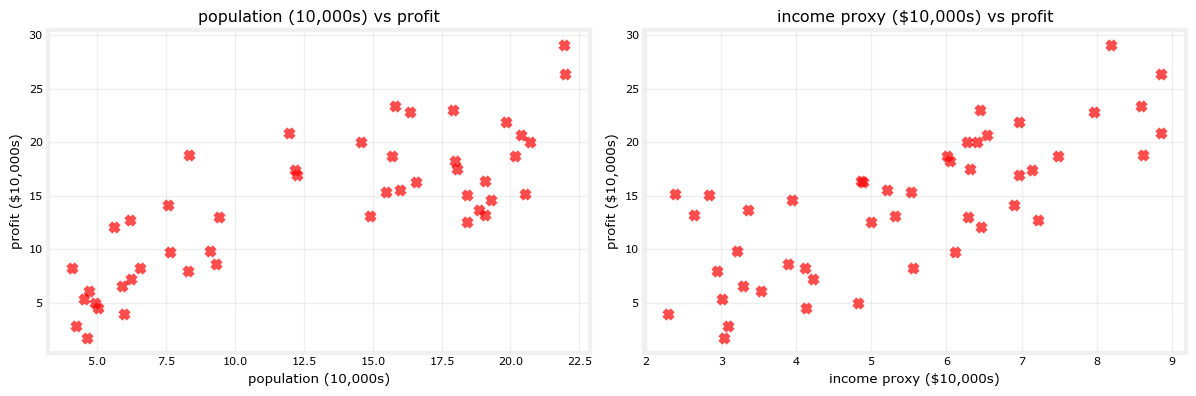

In [53]:
X_train, y_train = load_data_multi()
print('Type of X_train:', type(X_train))
print('Type of y_train:', type(y_train))
print('First row of X_train:', X_train[0])
print('First five elements of y_train:', y_train[:5])

# Scatter plots: each feature vs target
feature_names = ["population (10,000s)", "income proxy ($10,000s)"]
fig, axes = plt.subplots(1, X_train.shape[1], figsize=(6 * X_train.shape[1], 4), squeeze=False)
for j in range(X_train.shape[1]):
    ax = axes[0, j]
    ax.scatter(X_train[:, j], y_train, marker='x', c='r', alpha=0.7)
    xlab = feature_names[j] if j < len(feature_names) else f"feature {j}"
    ax.set_xlabel(xlab)
    ax.set_ylabel("profit ($10,000s)")
    ax.set_title(f"{xlab} vs profit")
    ax.grid(True, alpha=0.3)
plt.tight_layout()


#### 變數說明
- `X_train`：shape 為 (m, n) 的特徵矩陣（m 筆資料、n 個特徵）
  - 本測驗中 n = 2
  - `X_train[:,0]`：城市人口（單位：10,000 人）
  - `X_train[:,1]`：當地平均收入指標（單位：\$10,000）
- `y_train`：shape 為 (m,) 的標籤向量
  - 每月獲利（單位：\$10,000）


In [ ]:
print('The shape of X_train is:', X_train.shape)
print('The shape of y_train is:', y_train.shape)
print('Number of training examples (m):', X_train.shape[0])
print('Number of features (n):', X_train.shape[1])

<br>

### 2.3 特徵縮放（Feature Scaling）
多變量線性迴歸通常需要做特徵縮放（例如 z-score normalization），讓梯度下降更穩定、收斂更快。


In [ ]:
# UNQ_C1
# GRADED FUNCTION: zscore_normalize_features
def zscore_normalize_features(X):
    """Z-score normalize features.

    Args:
        X (ndarray): Shape (m, n) input features

    Returns:
        X_norm (ndarray): normalized features, shape (m, n)
        mu (ndarray): mean of each feature, shape (n,)
        sigma (ndarray): std of each feature, shape (n,)
    """
    ### START CODE HERE ###
    mu     = np.mean(X, axis=0)                
    sigma  = np.std(X, axis=0)                 
    X_norm = (X - mu) / sigma      
    ### END CODE HERE ###
    return X_norm, mu, sigma


In [ ]:
X_norm, mu, sigma = zscore_normalize_features(X_train)
print('mu:', mu)
print('sigma:', sigma)
print('First row of X_norm:', X_norm[0])

from utils.public_tests import *
zscore_normalize_features_test(zscore_normalize_features)

<br>

### 2.4 成本函數（Compute Cost）
多變量線性迴歸模型：
$$f_{w,b}(\mathbf{x}) = \mathbf{x}\cdot\mathbf{w} + b$$

成本函數：
$$J(\mathbf{w},b) = \frac{1}{2m} \sum_{i=0}^{m-1} (f_{w,b}(\mathbf{x}^{(i)}) - y^{(i)})^2$$


In [ ]:
# UNQ_C2
# GRADED FUNCTION: compute_cost_multi
def compute_cost_multi(X, y, w, b):
    """Compute cost for multivariate linear regression.

    Args:
        X (ndarray): Shape (m, n) features
        y (ndarray): Shape (m,) target values
        w (ndarray): Shape (n,) model parameters
        b (scalar): bias parameter
    Returns:
        cost (float): scalar cost value
    """
    m = X.shape[0]
    ### START CODE HERE ###
    f_wb = np.dot(X, w) + b;
    c = np.pow(f_wb - y, 2);
    cost = np.sum(c)*(1/(2*m));
    ### END CODE HERE ###
    return cost


In [ ]:
initial_w = np.zeros(X_norm.shape[1])
initial_b = 0.
cost = compute_cost_multi(X_norm, y_train, initial_w, initial_b)
print(f'Cost at initial w,b (zeros): {cost:.3f}')

from utils.public_tests import *
compute_cost_multi_test(compute_cost_multi)


**預期輸出（Expected Output）**：

<table>
  <tr>
    <td><b>Cost at initial w,b (zeros)</b></td>
    <td>120.388</td>
  </tr>
</table>


<br>

### 2.5 梯度計算（Compute Gradient）
梯度：
$$\frac{\partial J}{\partial b} = \frac{1}{m}\sum_{i=0}^{m-1} (f_{w,b}(\mathbf{x}^{(i)})-y^{(i)})$$
$$\frac{\partial J}{\partial \mathbf{w}} = \frac{1}{m}\sum_{i=0}^{m-1} (f_{w,b}(\mathbf{x}^{(i)})-y^{(i)})\mathbf{x}^{(i)}$$


In [ ]:
# UNQ_C3
# GRADED FUNCTION: compute_gradient_multi
def compute_gradient_multi(X, y, w, b):
    """Compute gradient for multivariate linear regression.
    
    Args:
        X (ndarray): Shape (m, n)
        y (ndarray): Shape (m,)
        w (ndarray): Shape (n,)
        b (scalar)
    Returns:
        dj_dw (ndarray): Shape (n,)
        dj_db (scalar)
    """
    m = X.shape[0]
    ### START CODE HERE ###
    losses = np.dot(X, w) - y #Shape (m, 1)
    dj_dw = np.dot(X.T, losses) * (1/m)
    dj_db = np.sum(losses) * (1/m)
    ### END CODE HERE ###
    return dj_dw, dj_db


In [ ]:
tmp_dj_dw, tmp_dj_db = compute_gradient_multi(X_norm, y_train, initial_w, initial_b)
print('dj_dw at initial w,b (zeros):', tmp_dj_dw)
print('dj_db at initial w,b (zeros):', tmp_dj_db)

from utils.public_tests import *
compute_gradient_multi_test(compute_gradient_multi)

**預期輸出（Expected Output）**：
<table>
  <tr>
    <td><b>dj_dw at initial w,b (zeros)</b></td>
    <td>[-5.13108179 -4.88920085]</td>
  </tr>
  <tr>
    <td><b>dj_db at initial w,b (zeros)</b></td>
    <td>-14.110691489361702</td>
  </tr>
</table>


<br>

### 2.6 梯度下降（Gradient Descent）
以下提供一個批次梯度下降（batch gradient descent）的參考實作（非評分）。


In [ ]:
def gradient_descent_multi(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    """Batch gradient descent for multivariate linear regression."""
    m = X.shape[0]
    w = copy.deepcopy(w_in)
    b = b_in
    J_history = []

    for i in range(num_iters):
        dj_dw, dj_db = gradient_function(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        if i < 100000:
            J_history.append(cost_function(X, y, w, b))
        if i % max(1, math.ceil(num_iters / 10)) == 0:
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}")
    return w, b, J_history


In [52]:
initial_w = np.zeros(X_norm.shape[1])
initial_b = 0.
alpha = 0.001
iterations = 1000

w, b, J_hist = gradient_descent_multi(X_norm, y_train, initial_w, initial_b,
                                     compute_cost_multi, compute_gradient_multi,
                                     alpha, iterations)
print('w,b found by gradient descent:', w, b)

Iteration    0: Cost   120.14
Iteration  100: Cost    96.82
Iteration  200: Cost    76.50
Iteration  300: Cost    58.95
Iteration  400: Cost    43.98
Iteration  500: Cost    31.47
Iteration  600: Cost    21.31
Iteration  700: Cost    13.42
Iteration  800: Cost     7.73
Iteration  900: Cost     4.20
w,b found by gradient descent: [2.90562164 2.73263479] 14.11069148936188


**預期輸出（Expected Output）**：
<table>
  <tr>
    <td><b>w,b found by gradient descent</b></td>
    <td>[2.90562164 2.73263479] 14.11069148936188</td>
  </tr>
</table>


接著，我們會把這些預測值畫出來，與原始資料點一起顯示，以觀察線性擬合的效果。

In [ ]:
# Predicted vs actual on training set
y_pred = np.dot(X_norm, w) + b
plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred, alpha=0.7)
lims = [min(y_train.min(), y_pred.min()), max(y_train.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', linewidth=2)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual profit ($10,000s)")
plt.ylabel("Predicted profit ($10,000s)")
plt.title("Predicted vs Actual (training set)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

<br>

**恭喜你完成這個多變量線性迴歸的測驗實驗**

#### 進階：用學到的參數做預測
試著輸入一個新城市的特徵（人口、平均收入），並用你學到的 `(w,b)` 預測獲利。
提示：要先用同一組 `mu`、`sigma` 做 z-score normalization，再丟進模型。
